# Introduction

This demo is meant to illustrate the steps in the image processing, which comprise of resizing and interpolating the images, creating a binary images through thesholding, using the Canny method to find the edges of the digit from the image and finally transforming this edge into a contour. This contour is then used to retrieve the features about the segmented objects, such as area and perimeter.

Another approach often used in 'tradional' image processing for segmentation of objects is the distance transform followed by the watershed method. However, in opencv the watershed method seemed to have some issues with grayscale image, so I choose the above specified method for segmentation instead.

The demo finishes with a short training session to find info about a number of perimeters which will be used in the main file for digit classification.

In [1]:
from mlxtend.data import loadlocal_mnist
import numpy as np
import matplotlib.pyplot as plt
import cv2 # OpenCV (CV stands for Computer Vision) is a famous library for image processing 
import statistics 

Select the MNIST training dataset:

In [2]:
directory = '/home/erik/Documents/Image-Classification/'

X, y = loadlocal_mnist(
        images_path= directory + 'train-images.idx3-ubyte', 
        labels_path= directory + 'train-labels.idx1-ubyte')

In [3]:
print('Dimensions of the dataset: %s x %s' % (X.shape[0], X.shape[1]))
#print('\n1st row', X[0])
print('Dimensions of first image: %s' % (X[0].shape[0]))

print('This means that the images are %s images, each with with 28 x 28 cells' % (X.shape[0]))

Dimensions of the dataset: 60000 x 784
Dimensions of first image: 784
This means that the images are 60000 images, each with with 28 x 28 cells


In [4]:
print('Digits:  0 1 2 3 4 5 6 7 8 9')
print('labels: %s' % np.unique(y))
print('Class distribution: %s' % np.bincount(y))

Digits:  0 1 2 3 4 5 6 7 8 9
labels: [0 1 2 3 4 5 6 7 8 9]
Class distribution: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


Here we can have a look at the raw, unprocessed images in the data set:

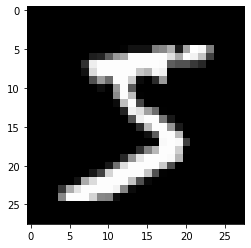

Index of image: 0, Label of image: 5


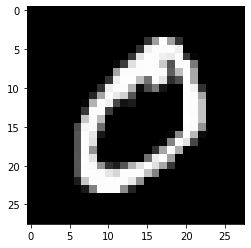

Index of image: 1, Label of image: 0


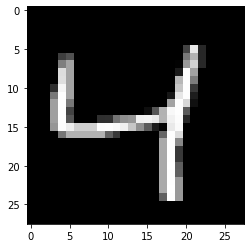

Index of image: 2, Label of image: 4


In [5]:
NrOfImagesToShow = 3

for i in range(0,NrOfImagesToShow):
    myimage = X[i].reshape((28,28))
    plt.imshow(myimage,'gray')
    plt.show() 
    print('Index of image: %s, Label of image: %s' %(i, y[i]))

# Image processing

Resize the image and use the Bilinear Interpolation method:

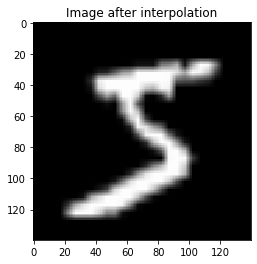

In [6]:
ImageIndex = 0  # Here you can choose which image you want to select

Image0 = X[ImageIndex]

# Make the image five times as big and use Bilinear Interpolation method
resizing = 5
Image = cv2.resize(Image0.reshape((28,28)),None, fx = resizing, fy = resizing, interpolation = cv2.INTER_LINEAR)

maxycoord = resizing * 28  # Will be used later on

plt.imshow(Image,'gray')
plt.title('Image after interpolation')
plt.show() 

Global thresholding to creating a binary image:

Pixel intensity threshold value: 35


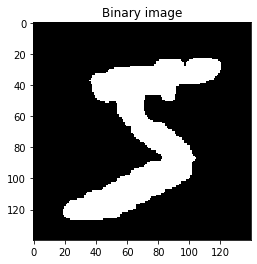

In [7]:
tvalue = statistics.mean(Image0)  # For the threshold value I'm using the mean of the pixel values
maxvalue = max(Image0)            # The maximum value present in the image

print('Pixel intensity threshold value: %s' %(tvalue))

ret,BinIm = cv2.threshold(Image,tvalue,maxvalue,cv2.THRESH_BINARY)

plt.imshow(BinIm,'gray')
plt.title('Binary image')
plt.show()

Create an edge and then a contour around the object:

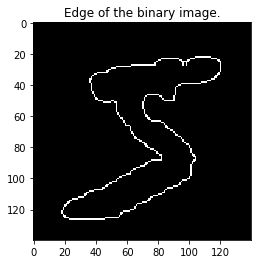

Numbers of contours found= 1


In [8]:
edged=cv2.Canny(BinIm, 10, 200)

plt.imshow(edged, 'gray')
plt.title('Edge of the binary image.')
plt.show()

(contours, _)=cv2.findContours(BinIm,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)

print('Numbers of contours found= ' + str(len(contours)))

# Descriptors

A number of descriptors of the object:

In [9]:
if len(contours) > 2:
    # Only for digit 8
    innerArea1 = cv2.contourArea(contours[0])
    innerArea2 = cv2.contourArea(contours[1])
    totalArea = cv2.contourArea(contours[2])
    realArea = totalArea - innerArea1 - innerArea2
    print('First inner area: %s, Second inner area: %s, Total area: %s, Actual area: %s' %(innerArea1, innerArea2, 
                                                                                           totalArea, realArea))
    
    contour = contours[2]

elif len(contours) == 2:
    # For digits 0, 6 and 9
    innerArea = cv2.contourArea(contours[0])
    totalArea = cv2.contourArea(contours[1])
    realArea = totalArea - innerArea
    print('Inner area: %s, Total area: %s, Actual area: %s' %(innerArea, totalArea, realArea))
    
    moments = cv2.moments(contours[0])
    xcentroid = moments['m10']/moments['m00']
    ycentroid = moments['m01']/moments['m00']
    print('xcentroid of inner area: %s, ycentroid of inner area: %s' %(xcentroid, ycentroid))
    print('Relative positioning on y scale: %s' %(ycentroid/maxycoord))
    
    contour = contours[1]
    
else:
    # For digits 1, 2, 3, 4, 5, 7
    realArea = cv2.contourArea(contours[0])
    print('Area: %s' %(realArea))
    
    contour = contours[0]
    
#Calculates a contour perimeter or a curve length.
perimeter = cv2.arcLength(contour, True)
print('Perimeter: %s' %(perimeter))
              
#Calculate the width, height and asepct ratio
rect = cv2.boundingRect(contour)
(startingx, startingy, width, height) = rect
aspect_ratio = height / width
print('Width: %s, Height: %s, Aspect ratio: %s' %(width, height, aspect_ratio))    

Area: 3781.5
Perimeter: 501.88939011096954
Width: 102, Height: 104, Aspect ratio: 1.0196078431372548


One more descriptor of the object, using the convex hull:

Area of the hull: 7354.5, Real area to convex hull area ratio: 0.514174994901081


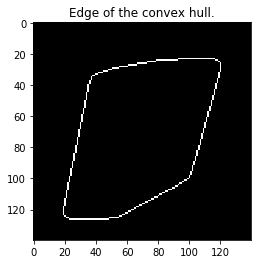

In [10]:
hull = cv2.convexHull(contour)
hullArea = cv2.contourArea(hull)

result = cv2.drawContours(0*edged, [hull], -1, 1)

print('Area of the hull: %s, Real area to convex hull area ratio: %s' %(hullArea, realArea/hullArea))

plt.imshow(result, 'gray')
plt.title('Edge of the convex hull.')
plt.show()

# Training parameters

For the digits 0, 1, 6, 7, 8 and 9 we can asume with relative safety that classification will be done succesfully based on a single shape feature, whether that be the number of countours like in the case of digit 8, or the inner area to total area ratio like in the case of digit 0.

However, the remaining digits 2, 3, 4, 5 and 7 don't have any of these distinguishing features. So instead we'll use a number of images from the training data for each of the digits, to find an average value for the area, perimiter, aspect ratio and convex hull area ratio for these digits.

We use the first 50 samples encountered of each of the digits to train the four parameters.

In [11]:
nrSamples = 50

index = 0
counter_2 = 0; AreaSum_2 = 0; PerimeterSum_2 = 0; AspectRatioSum_2 = 0; ConvexHullRatioSum_2 = 0
counter_3 = 0; AreaSum_3 = 0; PerimeterSum_3 = 0; AspectRatioSum_3 = 0; ConvexHullRatioSum_3 = 0
counter_4 = 0; AreaSum_4 = 0; PerimeterSum_4 = 0; AspectRatioSum_4 = 0; ConvexHullRatioSum_4 = 0
counter_5 = 0; AreaSum_5 = 0; PerimeterSum_5 = 0; AspectRatioSum_5 = 0; ConvexHullRatioSum_5 = 0
counter_7 = 0; AreaSum_7 = 0; PerimeterSum_7 = 0; AspectRatioSum_7 = 0; ConvexHullRatioSum_7 = 0

finished = False

while not finished:
    if y[index] == 2 or y[index] == 3 or y[index] == 4 or y[index] == 5 or y[index] == 7: 
        # Gathering info:
        Image0 = X[index]
        resizing = 5
        Image = cv2.resize(Image0.reshape((28,28)),None, fx = resizing, fy = resizing, interpolation = cv2.INTER_LINEAR)
        maxycoord = resizing * 28
        tvalue = statistics.mean(Image0)
        maxvalue = max(Image0)
        ret,BinIm = cv2.threshold(Image,tvalue,maxvalue,cv2.THRESH_BINARY)
        edged=cv2.Canny(BinIm, 10, 200)
        (contours, _)=cv2.findContours(BinIm,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
        
        # If somehow a digit somehow has multiple contours, which sometimes happens with the hand drawn digits, then skip it
        if len(contours) > 1:
            index += 1
            continue

        DigitArea = cv2.contourArea(contours[0])
        DigitPerimeter = cv2.arcLength(contours[0], True)
        (startingx, startingy, width, height) = cv2.boundingRect(contours[0])
        DigitAspectRatio = height / width
        hull = cv2.convexHull(contours[0])
        hullArea = cv2.contourArea(hull)
        DigitConvexHullRatio = DigitArea/hullArea

        if y[index] == 2:
            if counter_2 != nrSamples:
                AreaSum_2 += DigitArea; PerimeterSum_2 += DigitPerimeter
                AspectRatioSum_2 += DigitAspectRatio; ConvexHullRatioSum_2 += DigitConvexHullRatio
                counter_2 += 1
                
        if y[index] == 3:
            if counter_3 != nrSamples:
                AreaSum_3 += DigitArea; PerimeterSum_3 += DigitPerimeter
                AspectRatioSum_3 += DigitAspectRatio; ConvexHullRatioSum_3 += DigitConvexHullRatio
                counter_3 += 1
                                
        if y[index] == 4:
            if counter_4 != nrSamples:
                AreaSum_4 += DigitArea; PerimeterSum_4 += DigitPerimeter
                AspectRatioSum_4 += DigitAspectRatio; ConvexHullRatioSum_4 += DigitConvexHullRatio
                counter_4 += 1
                    
        if y[index] == 5:
            if counter_5 != nrSamples:
                AreaSum_5 += DigitArea; PerimeterSum_5 += DigitPerimeter
                AspectRatioSum_5 += DigitAspectRatio; ConvexHullRatioSum_5 += DigitConvexHullRatio  
                counter_5 += 1
                
        if y[index] == 7:
            if counter_7 != nrSamples:
                AreaSum_7 += DigitArea; PerimeterSum_7 += DigitPerimeter
                AspectRatioSum_7 += DigitAspectRatio; ConvexHullRatioSum_7 += DigitConvexHullRatio          
                counter_7 += 1
                    
    # Preparing for a new input image    
    index += 1
    if counter_2 == nrSamples and counter_3 == nrSamples and counter_4 == nrSamples and counter_5 == nrSamples and counter_7 == nrSamples:
        finished = True

        
# Averaging        
AreaAverage_2 = AreaSum_2 / nrSamples; PerimeterAverage_2 = PerimeterSum_2 / nrSamples
AspectRatioAverage_2 = AspectRatioSum_2 / nrSamples; ConvexHullRatioAverage_2 = ConvexHullRatioSum_2 / nrSamples

AreaAverage_3 = AreaSum_3 / nrSamples; PerimeterAverage_3 = PerimeterSum_3 / nrSamples
AspectRatioAverage_3 = AspectRatioSum_3 / nrSamples; ConvexHullRatioAverage_3 = ConvexHullRatioSum_3 / nrSamples

AreaAverage_4 = AreaSum_4 / nrSamples; PerimeterAverage_4 = PerimeterSum_4 / nrSamples
AspectRatioAverage_4 = AspectRatioSum_4 / nrSamples; ConvexHullRatioAverage_4 = ConvexHullRatioSum_4 / nrSamples

AreaAverage_5 = AreaSum_5 / nrSamples; PerimeterAverage_5 = PerimeterSum_5 / nrSamples
AspectRatioAverage_5 = AspectRatioSum_5 / nrSamples; ConvexHullRatioAverage_5 = ConvexHullRatioSum_5 / nrSamples

AreaAverage_7 = AreaSum_7 / nrSamples; PerimeterAverage_7 = PerimeterSum_7 / nrSamples
AspectRatioAverage_7 = AspectRatioSum_7 / nrSamples; ConvexHullRatioAverage_7 = ConvexHullRatioSum_7 / nrSamples

# Printing the results
print('\nFor digit 2, the following parameter values were collected: \nArea: %.1f, Perimeter: %.1f, Aspect ratio: %.4f, Convex hull area ratio: %.4f'
      % (AreaAverage_2, PerimeterAverage_2, AspectRatioAverage_2, ConvexHullRatioAverage_2))

print('\nFor digit 3, the following parameter values were collected: \nArea: %.1f, Perimeter: %.1f, Aspect ratio: %.4f, Convex hull area ratio: %.4f'
      % (AreaAverage_3, PerimeterAverage_3, AspectRatioAverage_3, ConvexHullRatioAverage_3))

print('\nFor digit 4, the following parameter values were collected: \nArea: %.1f, Perimeter: %.1f, Aspect ratio: %.4f, Convex hull area ratio: %.4f'
      % (AreaAverage_4, PerimeterAverage_4, AspectRatioAverage_4, ConvexHullRatioAverage_4))

print('\nFor digit 5, the following parameter values were collected: \nArea: %.1f, Perimeter: %.1f, Aspect ratio: %.4f, Convex hull area ratio: %.4f'
      % (AreaAverage_5, PerimeterAverage_5, AspectRatioAverage_5, ConvexHullRatioAverage_5))

print('\nFor digit 7, the following parameter values were collected: \nArea: %.1f, Perimeter: %.1f, Aspect ratio: %.4f, Convex hull area ratio: %.4f'
      % (AreaAverage_7, PerimeterAverage_7, AspectRatioAverage_7, ConvexHullRatioAverage_7))



For digit 2, the following parameter values were collected: 
Area: 3787.8, Perimeter: 450.8, Aspect ratio: 1.0413, Convex hull area ratio: 0.5960

For digit 3, the following parameter values were collected: 
Area: 3874.4, Perimeter: 501.2, Aspect ratio: 1.1720, Convex hull area ratio: 0.5882

For digit 4, the following parameter values were collected: 
Area: 3324.0, Perimeter: 435.5, Aspect ratio: 1.2360, Convex hull area ratio: 0.6052

For digit 5, the following parameter values were collected: 
Area: 3465.5, Perimeter: 471.8, Aspect ratio: 1.1121, Convex hull area ratio: 0.6030

For digit 7, the following parameter values were collected: 
Area: 3220.3, Perimeter: 411.8, Aspect ratio: 1.2691, Convex hull area ratio: 0.5977


The final submitted average values will depend on the number of samples used. i retreived the following result using 50 samples for each of the digits:

Digits = [2,3,4,5,7]

Areas = [3787.8, 3874.4, 3324.0, 3465.5, 3220.3]

Perimeters = [450.8, 501.2, 435.5, 471.8, 411.8]

AspectRatios = [1.0413, 1.1720, 1.2360, 1.1121, 1.2691]

ConvexHullRatios = [0.5960, 0.5882, 0.6052, 0.6030, 0.5977]



These values are hard coded into the main script, and will there be used for classification of all test data images.